<a href="https://colab.research.google.com/github/pajonnakuti/pyDataviz/blob/main/read_geotiff_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 80.3 MB/s eta 0:00:00


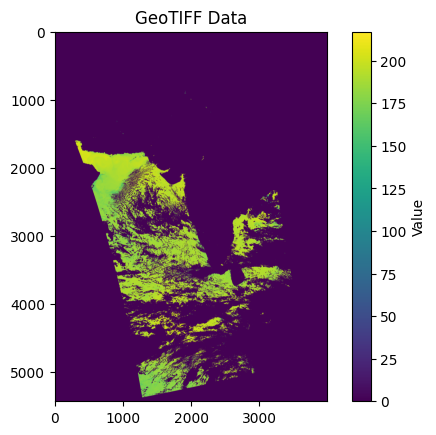

In [5]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF
file_path = "/content/gdrive/MyDrive/PyDataViz/20201001-151950Z-metop-2-sst.tif"
with rasterio.open(file_path) as src:
    data = src.read(1)   # Read the first band
    profile = src.profile  # Metadata (extent, CRS, etc.)

# Plot
plt.imshow(data, cmap="viridis")
plt.colorbar(label="Value")
plt.title("GeoTIFF Data")
plt.show()


In [7]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 61.3 MB/s eta 0:00:00


In [24]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd


In [20]:
# === Open GeoTIFF ===
file_path = "/content/gdrive/MyDrive/PyDataViz/20201001-151950Z-metop-2-sst.tif"
with rasterio.open(file_path) as src:
    data = src.read(1)  # first band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

In [21]:
with rasterio.open(file_path) as src:
    print("Driver:", src.driver)                # e.g., GTiff
    print("Width:", src.width)
    print("Height:", src.height)
    print("Bands:", src.count)
    print("CRS:", src.crs)                      # Coordinate Reference System
    print("Transform:", src.transform)          # Affine transform
    print("Bounds:", src.bounds)                # (minx, miny, maxx, maxy)
    print("Resolution:", src.res)               # Pixel size
    band1 = src.read(1)
    print("Min:", np.nanmin(band1))
    print("Max:", np.nanmax(band1))
    print("Mean:", np.nanmean(band1))


Driver: GTiff
Width: 4000
Height: 5427
Bands: 1
CRS: GEOGCS["Spherical Earth",DATUM["unnamed",SPHEROID["unnamed",6378137,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Transform: | 0.01, 0.00, 52.97|
| 0.00,-0.01, 43.23|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=52.974691353018656, bottom=-11.040236474766012, right=94.60668639888011, top=43.23001177152287)
Resolution: (0.010407998761465365, 0.010000045742820873)
Min: 0
Max: 217
Mean: 22.837277823843745


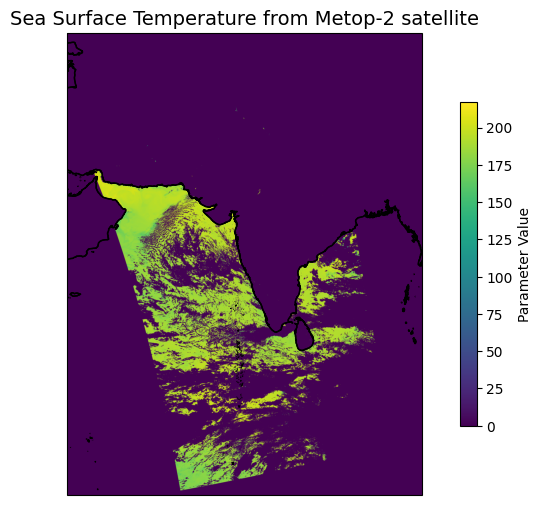

In [22]:
# === Plot ===
fig, ax = plt.subplots(figsize=(10, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})
# Add features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.COASTLINE, linestyle='')
ax.set_extent(extent, crs=ccrs.PlateCarree())  # zoom to data extent

# Show raster
img = ax.imshow(data, origin='upper', extent=extent,
                transform=ccrs.PlateCarree(), cmap='viridis')

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label("Parameter Value")

plt.title("Sea Surface Temperature from Metop-2 satellite", fontsize=14)
plt.show()



In [26]:
with rasterio.open(file_path) as src:
    band1 = src.read(1)
    info = {
        "Driver": src.driver,
        "Width": src.width,
        "Height": src.height,
        "Bands": src.count,
        "CRS": str(src.crs),
        "Bounds": src.bounds,
        "Resolution": src.res,
        "Min": float(np.nanmin(band1)),
        "Max": float(np.nanmax(band1)),
        "Mean": float(np.nanmean(band1)),
    }

# Convert to table
df = pd.DataFrame([info])
print(df)

# Save to CSV
df.to_csv("/content/gdrive/MyDrive/PyDataViz/geotiff_info.csv", index=False)


  Driver  Width  Height  Bands  \
0  GTiff   4000    5427      1   

                                                 CRS  \
0  GEOGCS["Spherical Earth",DATUM["unnamed",SPHER...   

                                              Bounds  \
0  (52.974691353018656, -11.040236474766012, 94.6...   

                                     Resolution  Min    Max       Mean  
0  (0.010407998761465365, 0.010000045742820873)  0.0  217.0  22.837278  


In [27]:
import json

# Save as JSON
with open("/content/gdrive/MyDrive/PyDataViz/geotiff_info.json", "w") as f:
    json.dump(info, f, indent=4)

print("GeoTIFF info saved to geotiff_info.json")


GeoTIFF info saved to geotiff_info.json


In [33]:
!pip install regionmask rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.0 MB/s eta 0:00:00


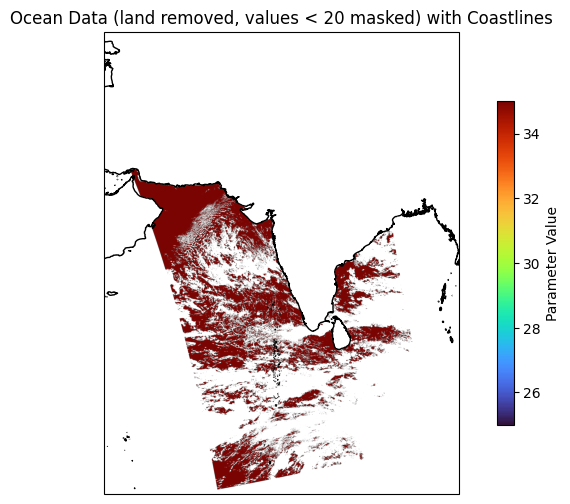

In [56]:
import regionmask
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load raster
da = rioxarray.open_rasterio("/content/gdrive/MyDrive/PyDataViz/20201001-151950Z-metop-2-sst.tif").squeeze()

# Create mask (land=1, ocean=NaN)
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(da.x, da.y)
da_masked = da.where(mask.isnull())  # keep only ocean

# Mask values in ocean less than 20
da_masked_ocean_filtered = da_masked.where(da_masked >= 20)

# === Plot with Cartopy and coastline ===
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set extent to match data
extent = [da.rio.bounds()[0], da.rio.bounds()[2], da.rio.bounds()[1], da.rio.bounds()[3]]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Display the raster data
img = ax.imshow(da_masked_ocean_filtered, extent=extent, origin="upper",
                transform=ccrs.PlateCarree(), cmap="turbo", vmin=25, vmax=35)

# Add coastlines
ax.coastlines(resolution='10m', color='black')

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Parameter Value")

plt.title("Ocean Data (land removed, values < 20 masked) with Coastlines")
plt.show()